In [212]:
import pandas as pd 
import matplotlib.pyplot as plt
import pickle
import json
from collections import defaultdict
import time
from datetime import datetime

In [4]:
# trips.txt: there are multiple trips per shuttle

df_trips = pd.read_csv('./passio-go/public/google_transit/trips.txt')
df_trips

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
0,777,48686.126106,670294,NaN,NaN,NaN,23714,48686,0,0
1,777,48686.126106,670295,NaN,NaN,NaN,23714,48686,0,0
2,777,48686.126106,670296,NaN,NaN,NaN,23714,48686,0,0
3,777,48686.126106,670297,NaN,NaN,NaN,23714,48686,0,0
4,777,48686.126106,670298,NaN,NaN,NaN,23714,48686,0,0
...,...,...,...,...,...,...,...,...,...,...
333,5707,48152.126137,670590,SEC Express,NaN,NaN,23728,48700,0,0
334,5707,48152.124657,670598,SEC Express,NaN,NaN,23727,48700,0,0
335,5707,48152.124657,670599,SEC Express,NaN,NaN,23727,48700,0,0
336,5707,48152.124657,670600,SEC Express,NaN,NaN,23728,48700,0,0


In [132]:
df_stop_times = pd.read_csv('./passio-go/public/google_transit/stop_times.txt')
df_stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,timepoint
0,670294,16:30:00,16:30:00,5049,1,NaN,NaN,NaN,1
1,670294,16:31:00,16:31:00,23509,2,NaN,NaN,NaN,1
2,670294,16:33:00,16:33:00,5050,3,NaN,NaN,NaN,1
3,670294,16:35:00,16:35:00,5042,4,NaN,NaN,NaN,1
4,670294,16:36:00,16:36:00,5043,5,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...
3202,670600,11:52:00,11:52:00,5041,5,NaN,NaN,NaN,1
3203,670601,12:30:00,12:30:00,5045,1,NaN,NaN,NaN,1
3204,670601,12:31:00,12:31:00,6854,2,NaN,NaN,NaN,1
3205,670601,12:35:00,12:35:00,5036,3,NaN,NaN,NaN,1


In [10]:
# shapes.txt: points that make the routes
df_shapes = pd.read_csv('./passio-go/public/google_transit/shapes.txt')
df_shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
0,48686,42.381867,-71.125325,1
1,48686,42.380436,-71.124350,2
2,48686,42.380421,-71.124387,3
3,48686,42.380187,-71.124944,4
4,48686,42.380167,-71.124994,5
...,...,...,...,...
5619,48700,42.362642,-71.124582,285
5620,48700,42.362604,-71.124607,286
5621,48700,42.362566,-71.124630,287
5622,48700,42.362443,-71.124688,288


In [39]:
# dump the coordinates for each route into a individual json files as nested lists: [[x1, y1], [x2, y2], ...]
'''
route_1.txt: allston loop
route_2.txt: quad sec
route_3.txt: quad yard express
'''
# unique_shape_ids = list(set(df_shapes['shape_id']))
wanted_ids = [48152, 48168, 48166] # allston_loop, quad_sec, quad_express

count = 0
for id in wanted_ids:
    shape = df_shapes[df_shapes['shape_id']==id]
    lat = list(shape['shape_pt_lat'])
    long = list(shape['shape_pt_lon'])
    coords_list = []

    for index in range(len(lat)):
        x_coord = lat[index]
        y_coord = long[index]
        coords_list.append([x_coord, y_coord])
        # plt.plot(lat, long)
    # print(coords_list)
    count += 1
    with open(f'./routes/route_{count}.json', 'w') as f:
        json.dump(coords_list, f)

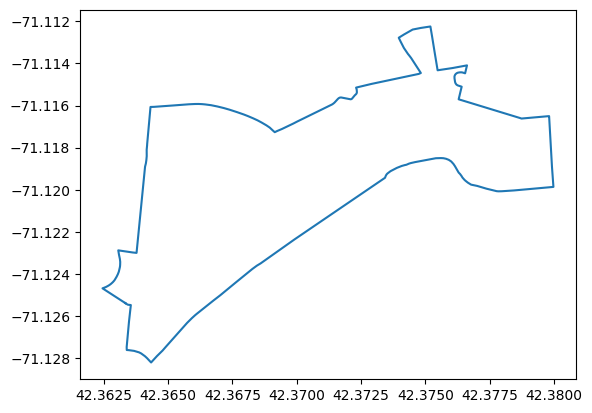

In [37]:
shape = df_shapes[df_shapes['shape_id']==48152]
lat = list(shape['shape_pt_lat'])
long = list(shape['shape_pt_lon'])
plt.plot(lat, long)

In [44]:
live_pos = open('./passio-go/public/live_files/vehiclePositions.json')
live_pos = json.load(live_pos)

In [47]:
live_pos.keys()

dict_keys(['header', 'entity'])

In [50]:
live_pos['header']

{'gtfs_realtime_version': '2.0', 'incrementality': 0, 'timestamp': 1708982484}

In [80]:
# live_pos['entity']: list of dictionarys, where each dict corresponds to a bus's current position information
live_pos['entity'][1]['vehicle']

{'vehicle': {'id': '2884', 'label': '206'},
 'position': {'latitude': 42.38051,
  'longitude': -71.1243845,
  'speed': 2.52,
  'bearing': 226},
 'current_stop_sequence': 8,
 'stop_id': '23509',
 'timestamp': 1708982480,
 'trip': {'trip_id': '670551'}}

In [57]:
'''
Given one dict:
    match 'trip_id' in trips.txt to get 'route_id' 
    match 'route_id' in routes.txt to only get routes [778, 2235, 790], [allston look, quad sec, quad express]
'''
df_trips = pd.read_csv('./passio-go/public/google_transit/trips.txt')
df_routes = pd.read_csv('./passio-go/public/google_transit/routes.txt')

In [61]:
df_routes[df_routes['route_short_name']=='AL']

,route_id,agency_id,route_short_name,route_long_name,route_type,route_color,route_text_color
1,778,831,AL,Allston Loop,3,A50606,FFFFFF


In [63]:
df_routes[df_routes['route_short_name']=='QSEC']

,route_id,agency_id,route_short_name,route_long_name,route_type,route_color,route_text_color
14,2235,831,QSEC,Quad SEC Direct,3,9467BD,FFFFFF


In [64]:
df_routes[df_routes['route_short_name']=='QE']

,route_id,agency_id,route_short_name,route_long_name,route_type,route_color,route_text_color
13,790,831,QE,Quad Express,3,136D1C,FFFFFF


In [79]:
# route_id 778: AL
# route_id 2235: QSEC
# route_id 790: QE

routes_of_interest = [778, 2235, 790]
trips_per_route = {}
routes_of_interest_df = df_trips[df_trips['route_id'].apply(lambda x: x in routes_of_interest)] # 136 trips that are either AL, QSEC, or QE

for route_id in routes_of_interest:
    trips_list = list(df_trips[df_trips['route_id']==route_id]['trip_id'].apply(lambda x: int(x)))
    trips_per_route[route_id] = trips_list

with open('trips_per_route.json', 'w') as f:
    json.dump(trips_per_route, f)

In [127]:
df_trips[df_trips['trip_id']==670180]

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
200,790,48152.126137,670180,NaN,NaN,NaN,23713,48166,0,0


In [142]:
df_stop_times[(df_stop_times['trip_id']==670375) & (df_stop_times['stop_id']==5045)]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,timepoint
1168,670375,09:15:00,09:15:00,5045,8,NaN,NaN,NaN,1


In [145]:
trips_per_route_dict = {"778": [661197, 661198, 661199, 661200, 661201, 661203, 661204, 664485, 661205, 661206, 661207, 661208, 661210, 661211, 661212, 661213, 661214, 661215, 661216, 661217, 661218, 661219, 661220, 661221, 661223, 661224, 661225, 661226, 661227, 661228, 661229, 661309, 661316, 661317, 661318, 661319, 661320, 670445, 670446, 670447, 670450, 670612, 670613, 670614, 670615, 670616], "2235": [661310, 670460, 670461, 670503, 670504, 670505, 670506, 670507, 670508, 670509, 670510, 670511, 670512, 670531, 670532, 670533, 670534, 670535, 670536, 670537, 670539, 670540, 670541, 670542, 670543, 670544, 670545, 670546, 670547, 670548, 670549, 670550, 670551, 670552, 670553, 670554, 670555, 670556], "790": [661290, 661291, 661292, 661293, 661294, 661295, 661296, 661297, 661298, 661299, 661300, 661301, 661302, 661303, 661304, 661305, 661306, 670178, 670179, 670180, 670181, 670182, 670183, 670184, 670185, 670186, 670187, 670188, 670189, 670190, 670191, 670192, 670193, 670194, 670195, 670196, 670197, 670198, 670201, 670202, 670203, 670204, 670205, 670206, 670207, 670208, 670209, 670210, 670211, 670212, 670213, 670214]}
trips_we_care_about = []

for key, value in trips_per_route_dict.items():
    trips_we_care_about += value 

trips_we_care_about = list(set(trips_we_care_about)) # 136 trips we care about
len(trips_we_care_about)

136

In [316]:
trips_we_care_about

[670208,
 670209,
 670210,
 670211,
 670212,
 670213,
 670214,
 670536,
 661197,
 661198,
 661199,
 661200,
 661201,
 661306,
 661203,
 661204,
 661205,
 661206,
 661207,
 661208,
 661210,
 661211,
 661212,
 661213,
 661214,
 661215,
 661216,
 661217,
 661218,
 661219,
 661220,
 661221,
 661223,
 661224,
 661225,
 661226,
 661227,
 661228,
 661229,
 670445,
 670446,
 670447,
 670450,
 670460,
 670461,
 670503,
 670504,
 670505,
 670506,
 670507,
 670508,
 670509,
 670510,
 670511,
 670512,
 661290,
 661291,
 661292,
 661293,
 661294,
 661295,
 661296,
 661297,
 661298,
 661299,
 661300,
 661301,
 661309,
 661310,
 661302,
 661303,
 661304,
 661305,
 670531,
 661316,
 661317,
 661318,
 661319,
 661320,
 670532,
 670533,
 670534,
 670540,
 670541,
 670535,
 670543,
 670537,
 670539,
 670544,
 670545,
 670542,
 670549,
 670546,
 670547,
 670548,
 670550,
 670551,
 670552,
 670553,
 670554,
 670555,
 670556,
 670612,
 670613,
 670614,
 670615,
 670616,
 664485,
 670178,
 670179,
 670180,
 

In [194]:
f = open('json_dump.json')
data_ivy = json.load(f)

g = open('kento_data.txt', 'r')
data_kento = g.readlines()

In [195]:
# data[i]['entity'][j]['trip_update']['trip']['trip_id']
# only look at stop '5045' (lamont)

# to expand, make a list of all routes that 3 buses pass through...it's hard coded but at this point i'm so tired

pred_time_list = []
actual_time_list = []

for i in range(len(data_ivy)):
    # for each bus id
    for j in range(len(data_ivy[i]['entity'])):
        trip_id = int(data_ivy[i]['entity'][j]['trip_update']['trip']['trip_id'])

        # if trip is along one of the three routes
        if trip_id in trips_we_care_about:
            pred_stop_times_list = data_ivy[i]['entity'][j]['trip_update']['stop_time_update']

            for stop_dict in pred_stop_times_list:
                # stop_dict: stop_id : ###, arrival : {time: ###}
                stop_id = int(stop_dict['stop_id'])
                pred_arrival_time = int(stop_dict['arrival']['time']) # in epoch
                # rn just looking at the lamont stop
                if stop_id == 5045:
                    actual_arrival_time_military = list(df_stop_times[(df_stop_times['trip_id']==trip_id) & (df_stop_times['stop_id']==stop_id)]['arrival_time'])
                    if len(actual_arrival_time_military) > 0:
                        actual_arrival_time_military = actual_arrival_time_military[0]
                        actual_arrival_time_military = time.strptime(f'2024-03-06 {actual_arrival_time_military}', '%Y-%m-%d %H:%M:%S')
                        actual_arrival_time_epoch = int(time.mktime(actual_arrival_time_military))

                        pred_time_list.append(pred_arrival_time)
                        actual_time_list.append(actual_arrival_time_epoch)

                        # actual_depart_time = df_stop_times[(df_stop_times['trip_id']==trip_id) & (df_stop_times['stop_id']==stop_id)]['departure_time']
            
# for trip_dict in data_kento:
#     trip_dict = json.loads(trip_dict) # convert str to dict
#     entity = trip_dict['tripUpdates']['entity']

#     for j in range(len(entity)):
#         trip_id = int(entity[j]['trip_update']['trip']['trip_id'])

#         # if trip is along one of the three routes
#         if trip_id in trips_we_care_about:
#             pred_stop_times_list = entity[j]['trip_update']['stop_time_update']

#             for stop_dict in pred_stop_times_list:
#                 # stop_dict: stop_id : ###, arrival : {time: ###}
#                 stop_id = int(stop_dict['stop_id'])
#                 pred_arrival_time = int(stop_dict['arrival']['time']) # in epoch
#                 # rn just looking at the lamont stop
#                 if stop_id == 5045:
#                     actual_arrival_time_military = list(df_stop_times[(df_stop_times['trip_id']==trip_id) & (df_stop_times['stop_id']==stop_id)]['arrival_time'])
#                     if len(actual_arrival_time_military) > 0:
#                         actual_arrival_time_military = actual_arrival_time_military[0]
#                         actual_arrival_time_military = time.strptime(f'2024-03-07 {actual_arrival_time_military}', '%Y-%m-%d %H:%M:%S')
#                         actual_arrival_time_epoch = int(time.mktime(actual_arrival_time_military))

#                         pred_time_list.append(pred_arrival_time)
#                         actual_time_list.append(actual_arrival_time_epoch)

In [320]:
# expand to all stops (not just lamont)
''' 
key: (trip_id, stop_id, actual_arrival_time_epoch) --> (trip_id, route_id, stop_id, bus_hour, actual_arrival_time_epoch)
value: [list of pred_arrival_times taken at different time stamps] --> average and then subtract from actual_arrival_time to get difference
'''
uncertainty_dict_all_preds = defaultdict(list) # values are lists

for i in range(len(data_ivy)):
    # for each bus id
    for j in range(len(data_ivy[i]['entity'])):
        trip_id = int(data_ivy[i]['entity'][j]['trip_update']['trip']['trip_id'])

        # if trip is along one of the three routes
        if trip_id in trips_we_care_about:
            pred_stop_times_list = data_ivy[i]['entity'][j]['trip_update']['stop_time_update']

            # find corresponding route
            route_id = ''
            for key, lst in trips_per_route_dict.items():
                if trip_id in lst:
                    route_id = key
                    break

            for stop_dict in pred_stop_times_list:
                # stop_dict: stop_id : ###, arrival : {time: ###}
                stop_id = int(stop_dict['stop_id'])
                pred_arrival_time = int(stop_dict['arrival']['time']) # in epoch
                actual_arrival_time_military_str = list(df_stop_times[(df_stop_times['trip_id']==trip_id) & (df_stop_times['stop_id']==stop_id)]['arrival_time'])
                
                if len(actual_arrival_time_military_str) > 0:
                    actual_arrival_time_military_str = actual_arrival_time_military_str[0]
                    actual_arrival_time_military = time.strptime(f'2024-03-06 {actual_arrival_time_military_str}', '%Y-%m-%d %H:%M:%S')
                    actual_arrival_time_hour = int(actual_arrival_time_military_str.split(':')[0])
                    actual_arrival_time_epoch = int(time.mktime(actual_arrival_time_military))

                    uncertainty_dict_all_preds[(route_id, stop_id, actual_arrival_time_hour, actual_arrival_time_epoch)].append(pred_arrival_time)

                    # actual_depart_time = df_stop_times[(df_stop_times['trip_id']==trip_id) & (df_stop_times['stop_id']==stop_id)]['departure_time']
            
# for trip_dict in data_kento:
#     trip_dict = json.loads(trip_dict) # convert str to dict
#     entity = trip_dict['tripUpdates']['entity']

#     for j in range(len(entity)):
#         trip_id = int(entity[j]['trip_update']['trip']['trip_id'])

#         # if trip is along one of the three routes
#         if trip_id in trips_we_care_about:
#             pred_stop_times_list = entity[j]['trip_update']['stop_time_update']

#             # find corresponding route
#             route_id = ''
#             for key, lst in trips_per_route_dict.items():
#                 if trip_id in lst:
#                     route_id = key
#                     break

#             for stop_dict in pred_stop_times_list:
#                 # stop_dict: stop_id : ###, arrival : {time: ###}
#                 stop_id = int(stop_dict['stop_id'])
#                 pred_arrival_time = int(stop_dict['arrival']['time']) # in epoch
#                 actual_arrival_time_military = list(df_stop_times[(df_stop_times['trip_id']==trip_id) & (df_stop_times['stop_id']==stop_id)]['arrival_time'])
                
#                 if len(actual_arrival_time_military) > 0:
#                     actual_arrival_time_military = actual_arrival_time_military[0]
#                     actual_arrival_time_military = time.strptime(f'2024-03-07 {actual_arrival_time_military}', '%Y-%m-%d %H:%M:%S')
#                     actual_arrival_time_epoch = int(time.mktime(actual_arrival_time_military))

#                     uncertainty_dict_all_preds[(route_id, stop_id, actual_arrival_time_epoch)].append(pred_arrival_time)

# average list of values and then subtract from actual_arrival_time to get difference              
# uncertainty_dict = {key: str(datetime.utcfromtimestamp(round(sum(values) / len(values))) - datetime.utcfromtimestamp(key[2])) for key, values in uncertainty_dict_all_preds.items()}
# uncertainty_dict = {key: str(datetime.utcfromtimestamp(max(values)) - datetime.utcfromtimestamp(key[2])) for key, values in uncertainty_dict_all_preds.items()}
# uncertainty_dict = {key: str(datetime.utcfromtimestamp(abs(max(values) - key[2]))).split()[1] for key, values in uncertainty_dict_all_preds.items()}

In [321]:
uncertainty_dict = {key: str(datetime.utcfromtimestamp(abs(round(sum(values) / len(values)) - key[2]))).split()[1] for key, values in uncertainty_dict_all_preds.items()}

# with open('uncertainties.json', 'w') as f:
#     json.dump(uncertainty_dict, f)

uncertainty_dict

{('790', 6248, 8, 1709732880): '14:17:29',
 ('790', 5044, 8, 1709733000): '14:18:03',
 ('790', 5049, 9, 1709734200): '14:32:55',
 ('790', 23509, 9, 1709734260): '14:35:19',
 ('790', 5050, 9, 1709734380): '14:36:03',
 ('790', 5042, 9, 1709734440): '14:37:20',
 ('790', 5043, 9, 1709734560): '14:38:57',
 ('790', 6248, 9, 1709734680): '14:39:53',
 ('790', 5044, 9, 1709734800): '14:40:28',
 ('2235', 58343, 8, 1709732400): '14:18:04',
 ('2235', 63189, 8, 1709732460): '14:19:11',
 ('2235', 5039, 8, 1709732520): '14:20:11',
 ('2235', 5040, 8, 1709732580): '14:21:39',
 ('2235', 5041, 8, 1709732760): '14:22:13',
 ('2235', 5042, 8, 1709732940): '14:24:08',
 ('2235', 5049, 9, 1709733600): '14:27:49',
 ('2235', 23509, 9, 1709733660): '14:30:56',
 ('2235', 5050, 9, 1709733720): '14:31:58',
 ('2235', 58344, 9, 1709733960): '14:32:38',
 ('2235', 5054, 9, 1709734020): '14:34:07',
 ('2235', 23930, 9, 1709734080): '14:35:39',
 ('2235', 63190, 9, 1709734140): '14:36:28',
 ('2235', 58343, 9, 1709734800): '

In [315]:
dict_to_df = defaultdict(list)

for key, value in uncertainty_dict.items():
    trip_id = key[0]
    stop_id = key[1]
    actual_arrival_time_epoch = key[2]
    pred_actual_diff_arrival = value

    dict_to_df['trip_id'].append(trip_id)
    dict_to_df['stop_id'].append(stop_id)
    dict_to_df['actual_arrival_time_epoch'].append(actual_arrival_time_epoch)
    dict_to_df['pred_actual_diff_arrival'].append(pred_actual_diff_arrival)

uncertainty_df = pd.DataFrame(dict_to_df)
uncertainty_df.to_csv('./passio-go/public/google_transit/uncertainties_by_route.txt', sep=',', index=False)

# ONLY KENTO'S DATA

In [273]:
# expand to all stops (not just lamont) -- looking only at kento's data
''' 
key: (trip_id, route_id, stop_id, bus_hour, actual_arrival_time_epoch)
value: [list of pred_arrival_times taken at different time stamps] --> average and then subtract from actual_arrival_time to get difference
'''
uncertainty_dict_all_preds = defaultdict(list) # values are lists
k = open('data-3-8.txt', 'r')
data_only_kento = k.readlines()[:100]

for trip_dict in data_only_kento:
    trip_dict = json.loads(trip_dict) # convert str to dict
    entity = trip_dict['tripUpdates']['entity']

    for j in range(len(entity)):
        trip_id = int(entity[j]['trip_update']['trip']['trip_id'])

        # if trip is along one of the three routes
        if trip_id in trips_we_care_about:
            # find corresponding route
            route_id = 0
            for key, lst in trips_per_route_dict.items():
                if trip_id in lst:
                    route_id = int(key)
                    break

            pred_stop_times_list = entity[j]['trip_update']['stop_time_update']

            for stop_dict in pred_stop_times_list:
                # stop_dict: stop_id : ###, arrival : {time: ###}
                stop_id = int(stop_dict['stop_id'])
                pred_arrival_time = int(stop_dict['arrival']['time']) # in epoch
                actual_arrival_time_military_str = list(df_stop_times[(df_stop_times['trip_id']==trip_id) & (df_stop_times['stop_id']==stop_id)]['arrival_time'])
                
                if len(actual_arrival_time_military_str) > 0:
                    actual_arrival_time_military_str = actual_arrival_time_military_str[0]
                    actual_arrival_time_military = time.strptime(f'2024-03-07 {actual_arrival_time_military_str}', '%Y-%m-%d %H:%M:%S')
                    actual_arrival_time_epoch = int(time.mktime(actual_arrival_time_military))

                    uncertainty_dict_all_preds[(trip_id, route_id, stop_id, actual_arrival_time_military_str.split(':')[0], actual_arrival_time_epoch)].append(pred_arrival_time)

# average list of values and then subtract from actual_arrival_time to get difference              
# uncertainty_dict = {key: str(datetime.utcfromtimestamp(round(sum(values) / len(values))) - datetime.utcfromtimestamp(key[2])) for key, values in uncertainty_dict_all_preds.items()}
# uncertainty_dict = {key: str(datetime.utcfromtimestamp(max(values)) - datetime.utcfromtimestamp(key[2])) for key, values in uncertainty_dict_all_preds.items()}
# uncertainty_dict = {key: str(datetime.utcfromtimestamp(abs(max(values) - key[2]))).split()[1] for key, values in uncertainty_dict_all_preds.items()}

In [275]:
uncertainty_dict = {str(key): str(datetime.utcfromtimestamp(abs(round(sum(values) / len(values)) - key[2]))).split()[1] for key, values in uncertainty_dict_all_preds.items()}

# with open('uncertainties.json', 'w') as f:
#     json.dump(uncertainty_dict, f)

uncertainty_dict

{"(670548, 2235, 63189, '13', 1709835660)": '01:58:38',
 "(670548, 2235, 5039, '13', 1709835720)": '18:08:53',
 "(670548, 2235, 5040, '13', 1709835780)": '18:10:19',
 "(670548, 2235, 5041, '13', 1709835960)": '18:10:57',
 "(670549, 2235, 58343, '14', 1709838300)": '03:25:59',
 "(670549, 2235, 63189, '14', 1709838360)": '02:06:33',
 "(670549, 2235, 5039, '14', 1709838420)": '18:16:49',
 "(670549, 2235, 5040, '14', 1709838480)": '18:18:15',
 "(670549, 2235, 5041, '14', 1709838490)": '18:18:53',
 "(670549, 2235, 5042, '14', 1709838540)": '18:20:43',
 "(670549, 2235, 23930, '14', 1709839630)": '12:56:03',
 "(670549, 2235, 63190, '14', 1709839680)": '02:02:44',
 "(670550, 2235, 58343, '14', 1709840400)": '03:27:39',
 "(670550, 2235, 63189, '14', 1709840460)": '02:08:06',
 "(670550, 2235, 5039, '14', 1709840520)": '18:18:23',
 "(670550, 2235, 5040, '14', 1709840580)": '18:19:49',
 "(670550, 2235, 5041, '14', 1709840760)": '18:20:27',
 "(670550, 2235, 5042, '14', 1709840940)": '18:22:17',
 "(

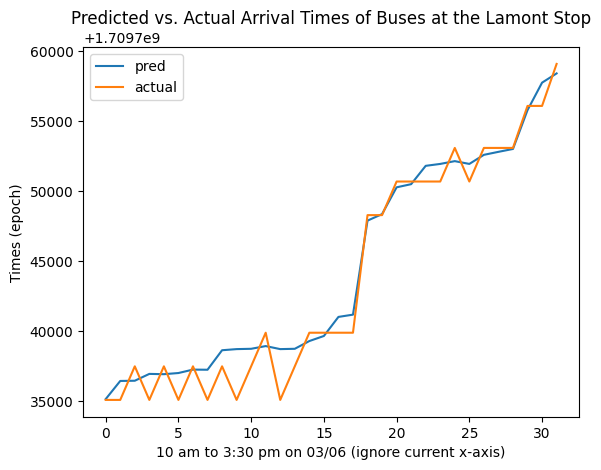

In [197]:
plt.plot(pred_time_list, label='pred')
plt.plot(actual_time_list, label='actual')
plt.title('Predicted vs. Actual Arrival Times of Buses at the Lamont Stop')
plt.xlabel('10 am to 3:30 pm on 03/06 (ignore current x-axis)')
plt.ylabel('Times (epoch)')
plt.legend()

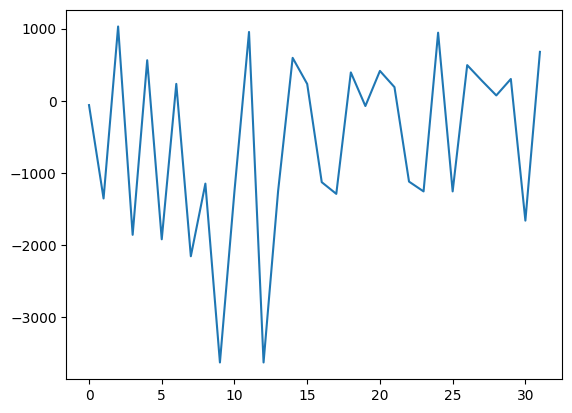

In [179]:
diff_time_list = [actual_time_list[i] - pred_time_list[i] for i in range(min(len(actual_time_list), len(pred_time_list)))]
plt.plot(diff_time_list)

In [155]:
time_tuple = time.strptime('2024-03-09 16:30:00', '%Y-%m-%d %H:%M:%S')
time_epoch = time.mktime(time_tuple)
time_epoch

1710019800.0

In [305]:
(data_ivy[0])['entity'][0]

{'id': '1',
 'trip_update': {'trip': {'trip_id': '670180'},
  'stop_time_update': [{'stop_id': '6248', 'arrival': {'time': 1709734657}},
   {'stop_id': '5044', 'arrival': {'time': 1709734691}},
   {'stop_id': '5039', 'arrival': {'time': 1709734701}}]}}